<a href="https://colab.research.google.com/github/hamsungmin/DataTrainAnalysis/blob/main/project_week7_%EC%A3%BC%EC%8B%9D%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주식 데이터 기반 딥러닝 예측 프로젝트

#### 프로젝트 목적
- 이 프로젝트의 목적은 주식 시장 데이터를 활용하여 딥러닝 모델을 통해 주가를 예측하는 것입니다.
- 평가 지표인 **MAE가 가장 낮은 모델, 데이터 전처리 방법을 찾는 것이 목적**입니다.

#### 데이터 개요
- 데이터는 yfinance 라이브러리를 통해 수집되며, 애플(AAPL), 마이크로소프트(MSFT), 테슬라(TSLA) 등 주요 기술 주식과  S&P 500 ETF(SPY), 3배 레버리지 나스닥 100 ETF(TQQQ) 등의 ETF를 포함합니다.
- 데이터는 날짜, 시가, 고가, 저가, 종가, 거래량, 거래 가치를 포함합니다.

#### 데이터 전처리에서 시도해볼 수 있는 것들
 - 정규화: 모델의 성능을 향상시키기 위해 데이터의 스케일을 조정할 수 있습니다.
 - 피처 엔지니어링(Option): 이동 평균, 볼린저 밴드 등 추가적인 피처를 생성하여 모델의 입력으로 사용할 수 있습니다.

#### 모델링 시 시도해볼 수 있는 것들
 - 다양한 딥러닝 아키텍처: RNN, LSTM, GRU 등 다양한 모델을 시도하여 성능을 비교할 수 있습니다.
 - 하이퍼파라미터 튜닝: 하이퍼파라미터를 조정하여 모델의 성능을 최적화할 수 있습니다.

#### 사용해야 할 평가 지표
 - MAE, MSE


---

In [ ]:
!pip install yfinance tqdm scikit-learn -q

In [ ]:
# PyTorch 준비
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.nn.functional as F

# 문제 :  Colab에서 GPU 사용 설정 후, 출력결과에 'cuda'가 출력되도록 하시오.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


# 데이터 수집

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

tickers = [
    "AAPL",  # 애플
    "MSFT",  # 마이크로소프트
    "SPY",   # S&P 500 ETF
    "TSLA",  # 테슬라
    "INTC",  # 인텔
    "NVDA",  # 엔비디아
    "AMZN",  # 아마존
    "META",  # 메타
    "AMD",   # AMD
    "TQQQ"   # 3배 레버리지 나스닥 100 ETF
]

In [ ]:
# 각 기업의 주가와 거래량 데이터 가져오기
from tqdm import tqdm

# 데이터를 저장할 리스트 생성
data_list = []

for ticker in tqdm(tickers, desc="데이터 수집 중"):
    stock = yf.Ticker(ticker)
    # 모든 기간의 데이터 가져오기
    df = stock.history(period="max")
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    # 거래대금 계산 (종가 * 거래량)
    df['Trading_Value'] = df['Close'] * df['Volume']
    df['Ticker'] = ticker

    data_list.append(df)

# 모든 데이터프레임을 하나로 합치기
all_data = pd.concat(data_list, axis=0)
# 인덱스 재설정
all_data = all_data.reset_index()

데이터 수집 중: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


In [ ]:
all_data

,Date,Open,High,Low,Close,Volume,Trading_Value,Ticker
0,1980-12-12 00:00:00-05:00,0.098485,0.098913,0.098485,0.098485,469033600,4.619270e+07,AAPL
1,1980-12-15 00:00:00-05:00,0.093775,0.093775,0.093347,0.093347,175884800,1.641829e+07,AAPL
2,1980-12-16 00:00:00-05:00,0.086924,0.086924,0.086495,0.086495,105728000,9.144982e+06,AAPL
3,1980-12-17 00:00:00-05:00,0.088636,0.089064,0.088636,0.088636,86441600,7.661859e+06,AAPL
4,1980-12-18 00:00:00-05:00,0.091206,0.091634,0.091206,0.091206,73449600,6.699045e+06,AAPL
...,...,...,...,...,...,...,...,...
77208,2025-08-25 00:00:00-04:00,89.620003,90.980003,89.029999,89.589996,40226300,3.603874e+09,TQQQ
77209,2025-08-26 00:00:00-04:00,89.309998,90.769997,88.839996,90.629997,42187300,3.823435e+09,TQQQ
77210,2025-08-27 00:00:00-04:00,90.139999,91.440002,89.540001,91.040001,45027600,4.099313e+09,TQQQ
77211,2025-08-28 00:00:00-04:00,91.279999,93.110001,90.510002,92.699997,45329000,4.201998e+09,TQQQ


In [ ]:
data_list[0]

,Open,High,Low,Close,Volume,Trading_Value,Ticker
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.098485,0.098913,0.098485,0.098485,469033600,4.619270e+07,AAPL
1980-12-15 00:00:00-05:00,0.093775,0.093775,0.093347,0.093347,175884800,1.641829e+07,AAPL
1980-12-16 00:00:00-05:00,0.086924,0.086924,0.086495,0.086495,105728000,9.144982e+06,AAPL
1980-12-17 00:00:00-05:00,0.088636,0.089064,0.088636,0.088636,86441600,7.661859e+06,AAPL
1980-12-18 00:00:00-05:00,0.091206,0.091634,0.091206,0.091206,73449600,6.699045e+06,AAPL
...,...,...,...,...,...,...,...
2025-08-25 00:00:00-04:00,226.479996,229.300003,226.229996,227.160004,30983100,7.038121e+09,AAPL
2025-08-26 00:00:00-04:00,226.869995,229.490005,224.690002,229.309998,54575100,1.251462e+10,AAPL
2025-08-27 00:00:00-04:00,228.610001,230.899994,228.259995,230.490005,31259500,7.205002e+09,AAPL


### 결측치 확인

In [ ]:
# 결측치 확인
print("전체 결측치 개수:")
all_data.isnull().sum()

전체 결측치 개수:


,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Trading_Value,0
Ticker,0


# 윈도우 데이터 생성

In [ ]:
# ==== 문제 : 윈도우 데이터를 생성하는 함수를 만드시오 ====
import numpy as np

def create_window_data(ticker_data, window_size, step_size=2):

    # 아래 조건으로 함수를 만드세요.

    """
    주가 데이터를 윈도우 슬라이딩하여 3차원 데이터로 변환하는 함수

    Parameters:
        ticker_data (DataFrame): 특정 종목의 원본 주가 데이터
        window_size (int): 윈도우 크기
        step_size (int): 윈도우 이동 간격

    Returns:
        numpy array: (샘플 수, 윈도우 크기, 피처 수) 형태의 3차원 데이터
    """
    X = []
    for i in range(0, len(ticker_data) - window_size, step_size):
        X.append(ticker_data.iloc[i:i + window_size].values)
    return np.array(X)

window_size = 30
step_size = 2
windowed_datas = []

# 스케일 진행시 오류로 인해 int형으로 변환 추후 timestamp로 다시 형변환
for ticker in all_data['Ticker'].unique():
    ticker_data = all_data[all_data['Ticker'] == ticker].copy()

    # 피처 엔지니어링 : 이동평균 적용
    ticker_data['MA5'] = ticker_data['Close'].rolling(5).mean()
    ticker_data['MA20'] = ticker_data['Close'].rolling(20).mean()
    ticker_data = ticker_data.dropna()  # NaN 제거

    # 스케일링 숫자만 가능함으로 string 데이터 제외
    numeric_cols = ticker_data.select_dtypes(include=[np.number]).columns
    ticker_data_numeric = ticker_data[numeric_cols]

    windowed = create_window_data(ticker_data_numeric, window_size, step_size)
    windowed_datas.append(windowed)

print("생성된 데이터 형태")
for i in range(len(windowed_datas)):
  print(windowed_datas[i].shape)


# 생성된 데이터 형태
# (5621, 30, 6)
# (4958, 30, 6)
# (4087, 30, 6)
# (1894, 30, 6)
# (5715, 30, 6)
# (3332, 30, 6)
# (3545, 30, 6)
# (1656, 30, 6)
# (5715, 30, 6)
# (1942, 30, 6)



생성된 데이터 형태
(5611, 30, 8)
(4948, 30, 8)
(4077, 30, 8)
(1884, 30, 8)
(5705, 30, 8)
(3322, 30, 8)
(3535, 30, 8)
(1646, 30, 8)
(5705, 30, 8)
(1932, 30, 8)


In [ ]:
# 원본 데이터와 윈도우 데이터 비교
print("원본 데이터 첫 번째 종목의 처음 5일치 데이터:")
first_ticker = all_data['Ticker'].unique()[0]
first_data = all_data[all_data['Ticker'] == first_ticker].sort_values('Date').head()
display(first_data[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'Trading_Value']])

print("\n윈도우 데이터의 첫 번째 윈도우(AAPL) 중 처음 5일치 데이터:")
# 스케일링 진행으로 인해 int 형만 나오게 변환
display(windowed_datas[0][0][:5])

원본 데이터 첫 번째 종목의 처음 5일치 데이터:


,Date,Ticker,Open,High,Low,Close,Volume,Trading_Value
0,1980-12-12 00:00:00-05:00,AAPL,0.098485,0.098913,0.098485,0.098485,469033600,4.619270e+07
1,1980-12-15 00:00:00-05:00,AAPL,0.093775,0.093775,0.093347,0.093347,175884800,1.641829e+07
2,1980-12-16 00:00:00-05:00,AAPL,0.086924,0.086924,0.086495,0.086495,105728000,9.144982e+06
3,1980-12-17 00:00:00-05:00,AAPL,0.088636,0.089064,0.088636,0.088636,86441600,7.661859e+06
4,1980-12-18 00:00:00-05:00,AAPL,0.091206,0.091634,0.091206,0.091206,73449600,6.699045e+06



윈도우 데이터의 첫 번째 윈도우(AAPL) 중 처음 5일치 데이터:


array([[1.09189837e-01, 1.09189837e-01, 1.08333506e-01, 1.08333506e-01,
        2.36992000e+07, 2.56741742e+06, 1.07477145e-01, 1.06342392e-01],
       [1.04908102e-01, 1.04908102e-01, 1.04479931e-01, 1.04479931e-01,
        2.30496000e+07, 2.40822062e+06, 1.06278265e-01, 1.06642147e-01],
       [1.04908198e-01, 1.05336370e-01, 1.04908198e-01, 1.04908198e-01,
        1.42912000e+07, 1.49926404e+06, 1.06107011e-01, 1.07220215e-01],
       [1.07049003e-01, 1.07905334e-01, 1.07049003e-01, 1.07049003e-01,
        1.40672000e+07, 1.50587974e+06, 1.06792094e-01, 1.08247897e-01],
       [1.06620790e-01, 1.06620790e-01, 1.06192619e-01, 1.06192619e-01,
        1.33952000e+07, 1.42247136e+06, 1.06192651e-01, 1.09125715e-01]])

예측할 종목을 하나 선택합니다.(AAPL)

In [ ]:
windowed_data = windowed_datas[0]

In [ ]:
windowed_data.shape

(5611, 30, 8)

# 데이터 전처리

In [ ]:
# 데이터 전처리
from sklearn.preprocessing import StandardScaler


# 문제 : 트레인 테스트 스플릿

split_index = int(len(windowed_data) * 0.9) # 데이터의 90%를 트레인 데이터로 사용
train_data = windowed_data[:split_index] # 90% 데이터를 학습
test_data = windowed_data[split_index:] # 나머지 10%를 테스트용으로 사용

X_train = train_data[:, :-1, :]
y_train = train_data[:, -1, 3]  # 'Close' 열의 인덱스는 3입니다.
X_test = test_data[:, :-1, :]
y_test = test_data[:, -1, 3]  # 'Close' 열의 인덱스는 3입니다.

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# 문제 : 데이터 스케일링
standardScalerX = StandardScaler()
standardScalerY = StandardScaler()

X_train_t = standardScalerX.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_t = standardScalerY.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
X_test_t = standardScalerX.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_t = standardScalerY.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

print("X_train_t shape:", X_train_t.shape)
print("y_train_t shape:", y_train_t.shape)
print("X_test_t shape:", X_test_t.shape)
print("y_test_t shape:", y_test_t.shape)
# 스케일링된 최종 데이터의 변수명 : X_train_t, y_train_t, X_test_t, y_test_t

X_train shape: (5049, 29, 8)
y_train shape: (5049,)
X_test shape: (562, 29, 8)
y_test shape: (562,)
X_train_t shape: (5049, 29, 8)
y_train_t shape: (5049,)
X_test_t shape: (562, 29, 8)
y_test_t shape: (562,)


# 모델 정의

In [ ]:
# ==== 문제 : 모델 정의 ====
# 레이어는 1-step(depth)으로 구성해도 됩니다.
# dropout 적용여부 결정 필요

class Seq2SeqModelTorch(nn.Module):
    def __init__(self, n_features, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # batch_first=True 로 입력을 (batch, seq, feature) 형태로 받도록

        # LSTM 모뎀 사용
        self.LSTM = nn.LSTM(n_features, hidden_units, batch_first=True)
        #Dropout 적용
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_units, 1)  # 1-step 가격 예측

    def forward(self, x):
        out, (hidden_state, cell_state) = self.LSTM(x)
        out = self.dropout(out)
        y = self.fc(out[:, -1, :])  # 마지막 시점만
        return y

        # 마지막 layer의 hidden state 사용

# 모델 생성
n_features = X_train_t.shape[2] #shapte[2] = feature 수
model_lstm = Seq2SeqModelTorch(n_features=n_features, hidden_units=64)
print(model_lstm)
# 모델 인스턴스 생성


Seq2SeqModelTorch(
  (LSTM): LSTM(8, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
class rnnModelTorch(nn.Module):
    def __init__(self, n_features, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # batch_first=True 로 입력을 (batch, seq, feature) 형태로 받도록

        # LSTM 모뎀 사용
        self.rnn = nn.RNN(n_features, hidden_units, batch_first=True)
        #Dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_units, 1)  # 1-step 가격 예측

    def forward(self, x):
        out, hidden_state = self.rnn(x)
        out = self.dropout(out)
        y = self.fc(out[:, -1, :])  # 마지막 시점만
        return y

        # 마지막 layer의 hidden state 사용

# 모델 생성
n_features = X_train_t.shape[2] #shapte[2] = feature 수
model_rnn = rnnModelTorch(n_features=n_features, hidden_units=64)
print(model_rnn)
# 모델 인스턴스 생성

rnnModelTorch(
  (rnn): RNN(8, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
class gruModelTorch(nn.Module):
    def __init__(self, n_features, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # batch_first=True 로 입력을 (batch, seq, feature) 형태로 받도록

        # LSTM 모뎀 사용
        self.gru = nn.GRU(n_features, hidden_units, batch_first=True)
        #Dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_units, 1)  # 1-step 가격 예측

    def forward(self, x):
        out, hidden_state = self.gru(x)
        out = self.dropout(out)
        y = self.fc(out[:, -1, :])  # 마지막 시점만
        return y

        # 마지막 layer의 hidden state 사용

# 모델 생성
n_features = X_train_t.shape[2] #shapte[2] = feature 수
model_gru = gruModelTorch(n_features=n_features, hidden_units=64)
print(model_gru)

gruModelTorch(
  (gru): GRU(8, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# ==== 문제 : 모델/Optimizer/손실함수 ====

# Adam 사용, Regularization 적용 여부 결정
import torch.optim as optim

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001, weight_decay=0.0001) # Adam 사용, L2 regularization 적용(weight_decay)
criterion_lstm = nn.MSELoss() # 손실함수


In [ ]:
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=0.001, weight_decay=0.0001) # Adam 사용, L2 regularization 적용(weight_decay)
criterion_rnn = nn.MSELoss() # 손실함수

In [ ]:
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001, weight_decay=0.0001) # Adam 사용, L2 regularization 적용(weight_decay)
criterion_gru = nn.MSELoss() # 손실함수

In [ ]:
# ==== 학습/검증 데이터 텐서로 변환 ====
# X_*_scaled: (N, T, F), y_*_scaled: (N, 1)

X_train_tensor = torch.tensor(X_train_t, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_t, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_t,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_t,  dtype=torch.float32)

print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([5049, 29, 8])
y_train_tensor shape: torch.Size([5049])
X_test_tensor shape: torch.Size([562, 29, 8])
y_test_tensor shape: torch.Size([562])


In [ ]:
# validation_split=0.2 적용
val_ratio = 0.2
n_train   = X_train_tensor.shape[0]
n_val     = int(n_train * val_ratio)

# 뒤쪽을 검증으로 떼면 시계열 누수 방지에 조금 더 안전
X_tr, X_val = X_train_tensor[:-n_val], X_train_tensor[-n_val:]
y_tr, y_val = y_train_tensor[:-n_val], y_train_tensor[-n_val:]

batch_size = 2000
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)


In [ ]:
# ====  문제 : 학습 루프 구성 ====
# Train과 Validation 적용

epochs = 15

history_lstm = {
    "loss": [], "val_loss": [],
    "mae": [], "val_mae": []
}
history_rnn = {
    "loss": [], "val_loss": [],
    "mae": [], "val_mae": []
}
history_gru = {
    "loss": [], "val_loss": [],
    "mae": [], "val_mae": []
}
for epoch in range(1, epochs + 1):
    model_lstm.train() # 학습 모드
    running_loss = 0.0
    running_mae  = 0.0

    for inputs, labels in train_loader:

        optimizer_lstm.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion_lstm(outputs, labels)
        loss.backward()
        optimizer_lstm.step()
        running_loss += loss.item() * inputs.size(0)
        running_mae += F.l1_loss(outputs, labels, reduction='sum').item()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = running_mae / len(train_loader.dataset)


    # Train loss
    history_lstm["loss"].append(epoch_loss)
    history_lstm["mae"].append(epoch_mae)

    model_lstm.eval()  # 평가 모드로 전환
    val_loss = 0.0
    val_mae  = 0.0

    with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
        for input_batch, label_batch in val_loader:

            outputs = model_lstm(input_batch)
            vloss = criterion_lstm(outputs, label_batch)

            val_loss += vloss.item() * input_batch.size(0)
            val_mae += F.l1_loss(outputs, label_batch, reduction='sum').item()

    epoch_vloss = val_loss / len(val_loader.dataset)
    epoch_vmae = val_mae / len(val_loader.dataset)


    # Validation loss
    history_lstm["val_loss"].append(epoch_vloss)
    history_lstm["val_mae"].append(epoch_vmae)

    print(f"Epoch {epoch} | loss: {epoch_loss:.4f}, mae: {epoch_mae:.4f} | val_loss: {epoch_vloss:.4f}, val_mae: {epoch_vmae:.4f}")




/tmp/ipython-input-525094600.py:31: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  running_mae += F.l1_loss(outputs, labels, reduction='sum').item()
/tmp/ipython-input-525094600.py:31: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  running_mae += F.l1_loss(outputs, labels, reduction='sum').item()
/tmp/ipython-input-525094600.py:51: UserWarning: Using a target size (torch.Size([1009])) that is different to the input size (torch.Size([1009, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_mae += F.l1_loss(outputs, label_batch, reduction='sum').item()


Epoch 1 | loss: 0.0390, mae: 240.0834 | val_loss: 3.9601, val_mae: 1445.7970
Epoch 2 | loss: 0.0388, mae: 237.7614 | val_loss: 4.0299, val_mae: 1468.5401
Epoch 3 | loss: 0.0383, mae: 243.4661 | val_loss: 4.0971, val_mae: 1490.5575
Epoch 4 | loss: 0.0379, mae: 256.9976 | val_loss: 4.1547, val_mae: 1509.5733
Epoch 5 | loss: 0.0383, mae: 274.5134 | val_loss: 4.2080, val_mae: 1527.0629
Epoch 6 | loss: 0.0385, mae: 280.2835 | val_loss: 4.2474, val_mae: 1539.8313
Epoch 7 | loss: 0.0385, mae: 280.7703 | val_loss: 4.2669, val_mae: 1545.9446
Epoch 8 | loss: 0.0381, mae: 270.3664 | val_loss: 4.2799, val_mae: 1549.7027
Epoch 9 | loss: 0.0376, mae: 250.8198 | val_loss: 4.2905, val_mae: 1552.5938
Epoch 10 | loss: 0.0379, mae: 233.3539 | val_loss: 4.3072, val_mae: 1557.6965
Epoch 11 | loss: 0.0382, mae: 224.0596 | val_loss: 4.3240, val_mae: 1563.3948
Epoch 12 | loss: 0.0376, mae: 232.9094 | val_loss: 4.3292, val_mae: 1565.8521
Epoch 13 | loss: 0.0375, mae: 254.8667 | val_loss: 4.3297, val_mae: 1566.

In [ ]:
for epoch in range(1, epochs + 1):
    model_rnn.train() # 학습 모드
    running_loss = 0.0
    running_mae  = 0.0

    for inputs, labels in train_loader:

        optimizer_rnn.zero_grad()
        outputs = model_rnn(inputs)
        loss = criterion_rnn(outputs, labels)
        loss.backward()
        optimizer_rnn.step()
        running_loss += loss.item() * inputs.size(0)
        running_mae += F.l1_loss(outputs, labels, reduction='sum').item()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = running_mae / len(train_loader.dataset)


    # Train loss
    history_rnn["loss"].append(epoch_loss)
    history_rnn["mae"].append(epoch_mae)

    model_rnn.eval()  # 평가 모드로 전환
    val_loss = 0.0
    val_mae  = 0.0

    with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
        for input_batch, label_batch in val_loader:
            outputs = model_rnn(input_batch)
            vloss = criterion_rnn(outputs, label_batch)
            val_loss += vloss.item() * input_batch.size(0)
            val_mae += F.l1_loss(outputs, label_batch, reduction='sum').item()

    epoch_vloss = val_loss / len(val_loader.dataset)
    epoch_vmae = val_mae / len(val_loader.dataset)


    # Validation loss
    history_rnn["val_loss"].append(epoch_vloss)
    history_rnn["val_mae"].append(epoch_vmae)

    print(f"Epoch {epoch} | loss: {epoch_loss:.4f}, mae: {epoch_mae:.4f} | val_loss: {epoch_vloss:.4f}, val_mae: {epoch_vmae:.4f}")



/tmp/ipython-input-1262575612.py:14: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  running_mae += F.l1_loss(outputs, labels, reduction='sum').item()
/tmp/ipython-input-1262575612.py:14: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  running_mae += F.l1_loss(outputs, labels, reduction='sum').item()
/tmp/ipython-input-1262575612.py:32: UserWarning: Using a target size (torch.Size([1009])) that is different to the input size (torch.Size([1009, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_mae += F.l1_loss(outputs, label_batch, reduction='sum').item()


Epoch 1 | loss: 0.1270, mae: 659.1979 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 2 | loss: 0.1273, mae: 659.3865 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 3 | loss: 0.1266, mae: 656.8448 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 4 | loss: 0.1274, mae: 659.8183 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 5 | loss: 0.1276, mae: 661.0378 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 6 | loss: 0.1271, mae: 659.6984 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 7 | loss: 0.1269, mae: 658.9767 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 8 | loss: 0.1272, mae: 659.5945 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 9 | loss: 0.1273, mae: 659.7655 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 10 | loss: 0.1279, mae: 661.1449 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 11 | loss: 0.1273, mae: 659.0903 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 12 | loss: 0.1269, mae: 658.6110 | val_loss: 4.7690, val_mae: 1708.9491
Epoch 13 | loss: 0.1272, mae: 658.9815 | val_loss: 4.7690, val_mae: 1708.

In [ ]:
for epoch in range(1, epochs + 1):
    model_gru.train() # 학습 모드
    running_loss = 0.0
    running_mae  = 0.0

    for inputs, labels in train_loader:

        optimizer_gru.zero_grad()
        outputs = model_gru(inputs)
        loss = criterion_gru(outputs, labels)
        loss.backward()
        optimizer_gru.step()
        running_loss += loss.item() * inputs.size(0)
        running_mae += F.l1_loss(outputs, labels, reduction='sum').item()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_mae = running_mae / len(train_loader.dataset)


    # Train loss
    history_gru["loss"].append(epoch_loss)
    history_gru["mae"].append(epoch_mae)

    model_gru.eval()  # 평가 모드로 전환
    val_loss = 0.0
    val_mae  = 0.0

    with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
        for input_batch, label_batch in val_loader:

            outputs = model_gru(input_batch)
            vloss = criterion_gru(outputs, label_batch)

            val_loss += vloss.item() * input_batch.size(0)
            val_mae += torch.sum(torch.abs(outputs - label_batch)).item()

    epoch_vloss = val_loss / len(val_loader.dataset)
    epoch_vmae = val_mae / len(val_loader.dataset)


    # Validation loss
    history_gru["val_loss"].append(epoch_vloss)
    history_gru["val_mae"].append(epoch_vmae)

    print(f"Epoch {epoch} | loss: {epoch_loss:.4f}, mae: {epoch_mae:.4f} | val_loss: {epoch_vloss:.4f}, val_mae: {epoch_vmae:.4f}")



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/tmp/ipython-input-478130396.py:14: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  running_mae += F.l1_loss(outputs, labels, reduction='sum').item()
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=

Epoch 1 | loss: 0.2040, mae: 861.2099 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 2 | loss: 0.2040, mae: 861.5236 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 3 | loss: 0.2046, mae: 863.4182 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 4 | loss: 0.2040, mae: 860.7980 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 5 | loss: 0.2029, mae: 858.5963 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 6 | loss: 0.2043, mae: 862.3927 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 7 | loss: 0.2051, mae: 863.5221 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 8 | loss: 0.2032, mae: 860.3147 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 9 | loss: 0.2041, mae: 861.7722 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 10 | loss: 0.2039, mae: 860.8516 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 11 | loss: 0.2044, mae: 862.2341 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 12 | loss: 0.2049, mae: 863.1238 | val_loss: 4.0364, val_mae: 1477.3314
Epoch 13 | loss: 0.2047, mae: 862.6817 | val_loss: 4.0364, val_mae: 1477.

# 학습 결과 시각화

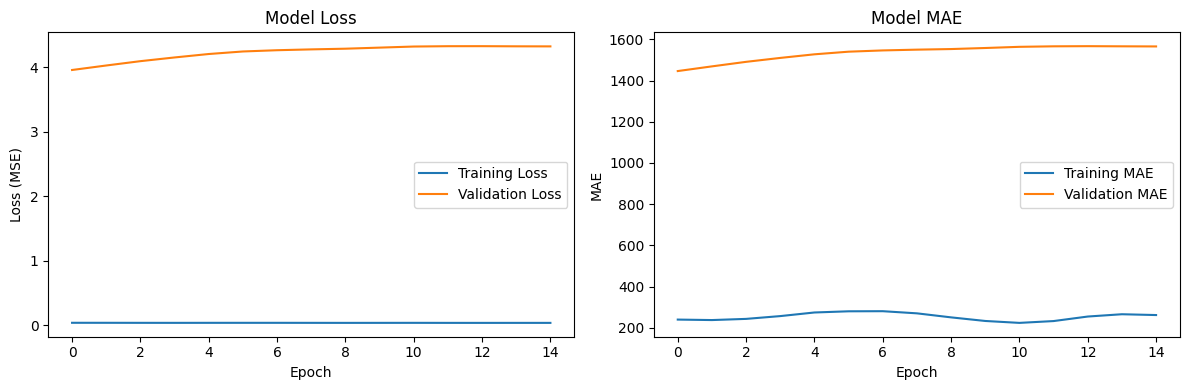

In [ ]:
import matplotlib.pyplot as plt

# Visualize training results
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm['loss'], label='Training Loss')
plt.plot(history_lstm['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm['mae'], label='Training MAE')
plt.plot(history_lstm['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ==== 예측 ====
# 문제 :  X_test_scaled 중 최근 30개 윈도우만 사용하는 코드


recent_30_X_test = X_test_tensor[-30:]
model_lstm.eval()
# 문제 : 모델 예측하여 y_pred_scaled_t 변수 생성하는 코드
with torch.no_grad():  # gradient 계산 비활성화
    y_pred_scaled_t = model_lstm(recent_30_X_test)

# 스케일 되돌리기
y_pred_scaled = y_pred_scaled_t.numpy()
y_pred = standardScalerY.inverse_transform(y_pred_scaled)

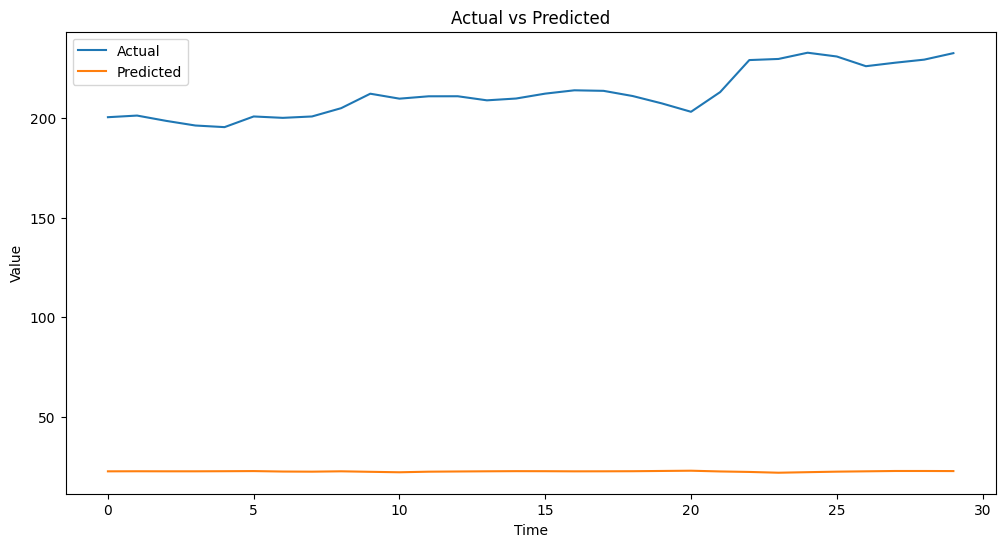

In [ ]:
# X_test 중에서 최근 30일만 가지고 테스트

# 실제값과 예측값 비교
plt.figure(figsize=(12, 6))
plt.plot(y_test[-30:], label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
